## Forecasting Bitcoin Prices with Time Series

### Natália Faraj Murad

   The goal here is to predict bitcoin prices using time series models. The bitcoin data was downloaded using the Yahoo Finance API. Data were explored and processed to be ready as input to the models. Four models were adjusted and evaluated: Naive Bayes, ARIMA, SARIMAX and Prophet. All of them presented a good result, unless Naive Bayes. The models were created considering a daily period.

In [1]:
# Silence warnings
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Data Manipulation
import pandas as pd
from pandas import Series
from pandas.tseries.offsets import DateOffset
import numpy as np
import scipy
from scipy import stats
import scipy.stats as scs
import itertools
from scipy.special import boxcox, inv_boxcox

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Data Source
import yfinance as yf

# Stats models
import statsmodels
import statsmodels.api as sm
import statsmodels.stats as sms
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics import tsaplots
import pmdarima as pm

# Date tools
from datetime import datetime, timedelta, date

# Prophet model
import prophet
from prophet import Prophet

# Imports for model metrics and performance
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error
import plotly as py
import plotly.express as px
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.preprocessing import MinMaxScaler

# Graphic params
plt.rcParams["figure.figsize"] = (14,6)
plt.style.use('fivethirtyeight')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

## Load the data

Using Yahoo Finance API to get the Bitcoin Prices Data.

In [2]:
data = yf.download(tickers='BTC-USD', start = '2015-01-01', end = date.today(), interval = '1D')

[*********************100%***********************]  1 of 1 completed


Setting Date as index.

In [3]:
dataClose = data['Close'].reset_index()
dataCloseSerie = dataClose.set_index('Date')

In [4]:
# Data Visualization
data.head()

Open        High         Low       Close   Adj Close    Volume
Date                                                                            
2015-01-01  320.434998  320.434998  314.002991  314.248993  314.248993   8036550
2015-01-02  314.079010  315.838989  313.565002  315.032013  315.032013   7860650
2015-01-03  314.846008  315.149994  281.082001  281.082001  281.082001  33054400
2015-01-04  281.145996  287.230011  257.612000  264.195007  264.195007  55629100
2015-01-05  265.084015  278.341003  265.084015  274.473999  274.473999  43962800

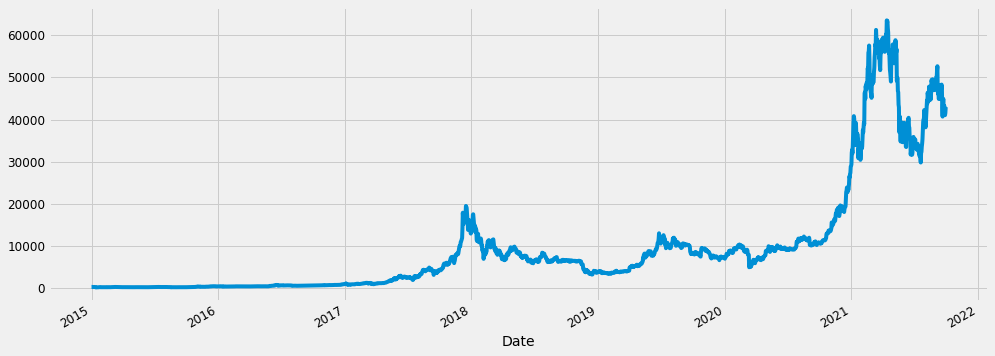

In [5]:
# Plot temporal serie
data.Close.plot(figsize = (15, 6))
plt.show()

## Stationarity

In [6]:
# Defining a function to test serie stationarity.
def stationarity_test(serie):
    
    # Calculate mobile stats
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot mobile stats
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Mobile Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Standard Deviation')
    plt.legend(loc = 'best')
    plt.title('Mobile Stats - Mean & Standard Deviation')
    plt.show()
    
    # Dickey-Fuller Test:
    # Print
    print('\nDickey-Fuller Test Result:\n')

    # Test
    dftest = adfuller(serie, autolag = 'AIC')

    # Output
    dfout= pd.Series(dftest[0:4], index = ['Test Stats',
                                               'p-value',
                                               'Number of Lags',
                                               'Number of Used Observations'])

    # Loop for each test output
    for key, value in dftest[4].items():
        dfout['Critic Value (%s)'%key] = value

    # Print
    print (dfout)
    
    # Test p-value
    print ('\nConclusion:')
    if dfout[1] > 0.05:
        print('\nO p-valuer > 0.05 and, therefore, we have no evidences to reject H0.')
        print('This serie probably is not stationary.')
    else:
        print('\nO p-value < 0.05 and, therefore, we have evidences to reject H0.')
        print('This serie probably is stationary')

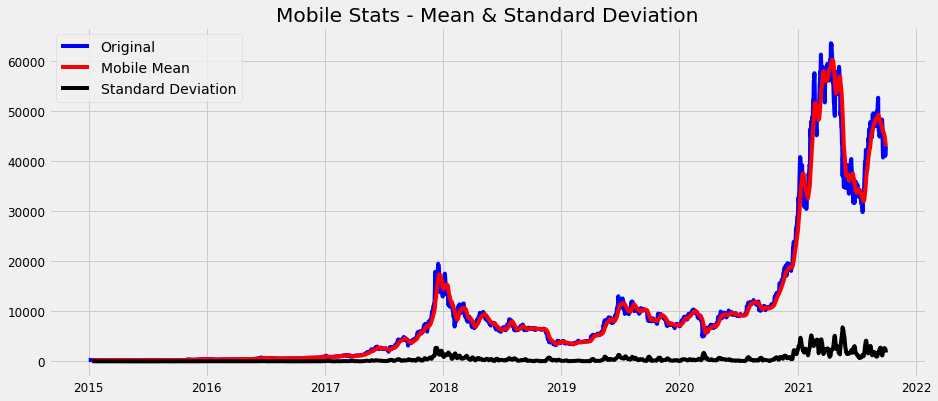


Dickey-Fuller Test Result:

Test Stats                       -0.529893
p-value                           0.886050
Number of Lags                   27.000000
Number of Used Observations    2433.000000
Critic Value (1%)                -3.433041
Critic Value (5%)                -2.862729
Critic Value (10%)               -2.567403
dtype: float64

Conclusion:

O p-valuer > 0.05 and, therefore, we have no evidences to reject H0.
This serie probably is not stationary.


In [7]:
# Apply function
stationarity_test(data['Close'])

The serie must be stationary to be passed to the model. A serie is stationary when its properties like mean and variance remain constant over time. This series will be differentiated in order to get stationary.

## Decomposition

In [8]:
# Decompose - Addictive
result_add = seasonal_decompose(data['Close'], model = 'additive', period=365, extrapolate_trend = 'freq')

# Plot
result_add.plot()
plt.show()

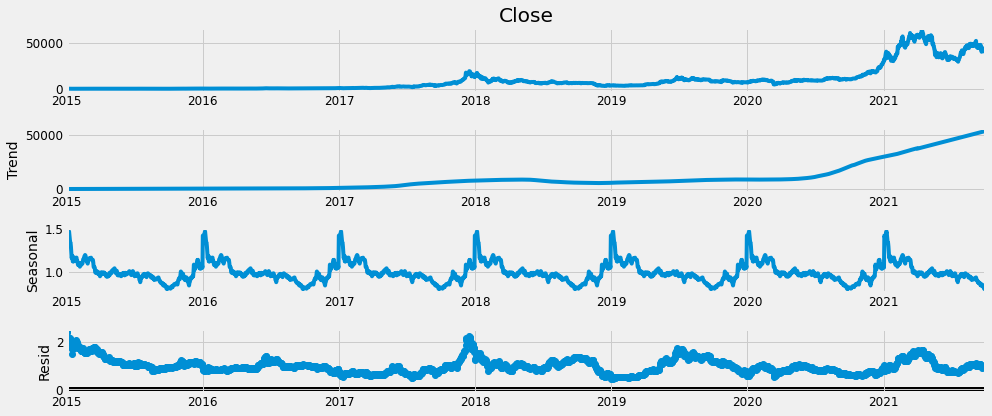

In [9]:
# Decompose - Multuplicative 
result_mul = seasonal_decompose(data['Close'], model = 'multiplicative', period = 365, extrapolate_trend = 'freq')

# Plot
result_mul.plot()
plt.show()

In [10]:
# Extracting Components
# Observations = (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis = 1)
df_reconstructed.columns = ['Seasonal', 'Trend', 'Resid', 'Observed_Values']
df_reconstructed.head()

Seasonal      Trend     Resid  Observed_Values
Date                                                      
2015-01-01  1.419184  91.147847  2.429343       314.248993
2015-01-02  1.407753  91.980494  2.432946       315.032013
2015-01-03  1.383449  92.813141  2.189074       281.082001
2015-01-04  1.376423  93.645789  2.049673       264.195007
2015-01-05  1.421696  94.478436  2.043440       274.473999

This serie presents a trend of increasing since 2020. It also have a annual seasonal component and random residuals.

## Autocorrelation

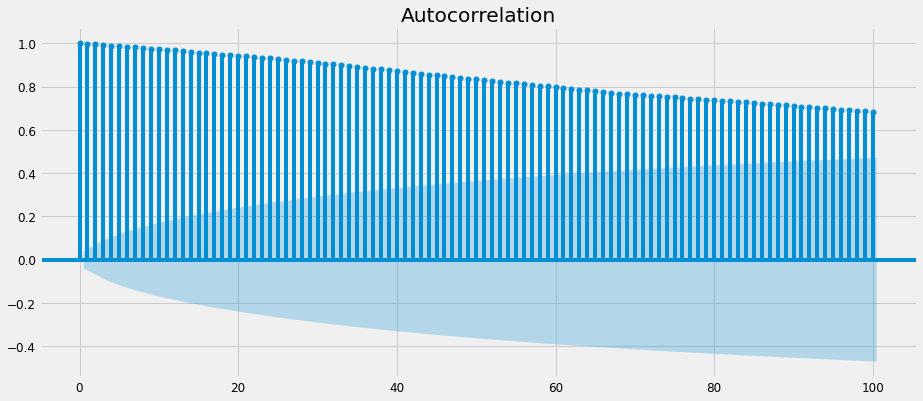

In [11]:
# Plot ACF (Auto Correlation)
acf_plot = plot_acf(data.Close, lags = 100)

This serie is strongly autocorrelated.

## Box Cox Transformation

Using Box Transformation in the serie because the series does not have constant variance.

In [12]:
data['Close_Box'], lmbda = stats.boxcox(data.Close)

## Differentiation

Defining functions to differenciate the serie to transform it in stationary and a function to get the real values back later.

In [13]:
# Differentiation function
def diffFunc(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff


# invert differenced value
def inverse_difference(history, yhat):
    desdiff = list()
    for i in range(1, len(yhat)):
        valued = yhat[i] + history[i-1]
        desdiff.append(valued)
    return desdiff

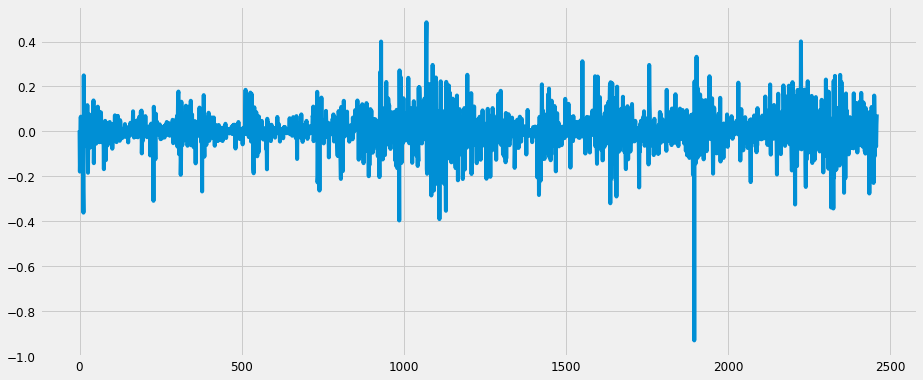

In [14]:
# Differentiation of 1st order
cox_diff = diffFunc(data.Close_Box)
plt.plot(cox_diff);

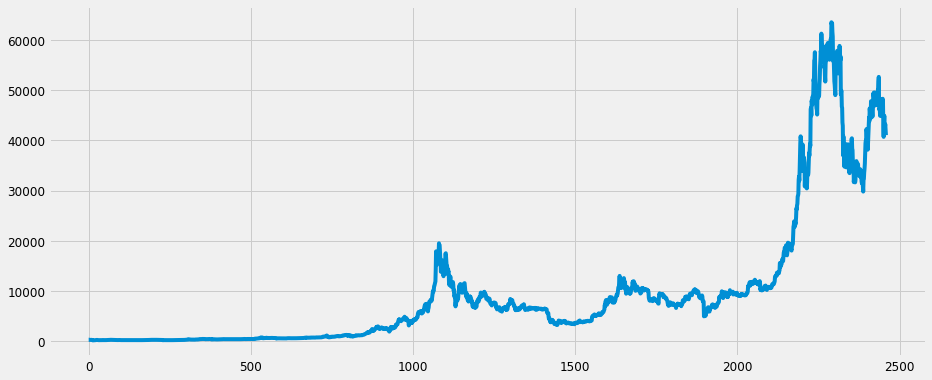

In [15]:
## testing undiff function
undif = inverse_difference(data['Close'], cox_diff)
undif
plt.plot(undif);

In [16]:
len(cox_diff)

2460

In [17]:
# Convert in df
cox_diff = pd.DataFrame(cox_diff) 

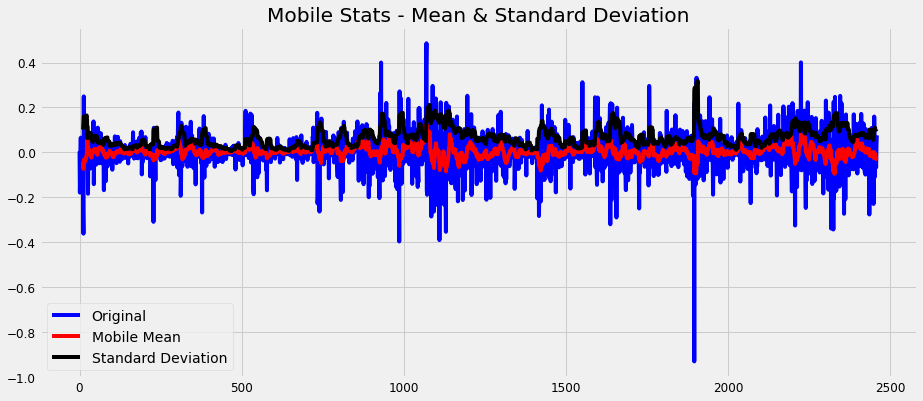


Dickey-Fuller Test Result:

Test Stats                    -1.471611e+01
p-value                        2.798389e-27
Number of Lags                 9.000000e+00
Number of Used Observations    2.450000e+03
Critic Value (1%)             -3.433022e+00
Critic Value (5%)             -2.862720e+00
Critic Value (10%)            -2.567398e+00
dtype: float64

Conclusion:

O p-value < 0.05 and, therefore, we have evidences to reject H0.
This serie probably is stationary


In [18]:
# Testing if the differentiation was enough
stationarity_test(cox_diff)

In [19]:
# Remove NA values generated
cox_diff.dropna(inplace=True)

In [20]:
x = pd.Series([0])
cox_diff = pd.concat([x, cox_diff])
data.reset_index()

data = data.reset_index()
cox_diff = cox_diff.set_index(data['Date'])
data = data.set_index('Date')

In [21]:
data['cox_diff'] = cox_diff

## Function to evaluate performance of the model

In [22]:
# Accuracy of the model
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE of predictions is {}'.format(round(mse, 2))+
                  '\nRMSE of predictions is {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE of predictions is {}'.format(round(mape, 2))))

## Split Train and Test

In [23]:
# Split test and train
X = data
train_size = int(len(X) * 0.80)
trainset, testset = X[0:train_size], X[train_size:]

In [24]:
target = trainset['cox_diff']

## Naive Bayes

In [25]:
# Create an array with target var values of trainset
array_count_train = np.asarray(target)
array_count_train

array([ 0.        ,  0.00392918, -0.17923908, ..., -0.04434739,
       -0.09800923,  0.02277476])

In [26]:
# Copy of validation data
df_valid_cp = testset.copy()
df_valid_cp.head()

Open         High          Low        Close    Adj Close       Volume  Close_Box  cox_diff
Date                                                                                                         
2020-05-23  9185.062500  9302.501953  9118.108398  9209.287109  9209.287109  27727866812  13.403961  0.005995
2020-05-24  9212.283203  9288.404297  8787.250977  8790.368164  8790.368164  32518803300  13.308030 -0.095931
2020-05-25  8786.107422  8951.005859  8719.667969  8906.934570  8906.934570  31288157264  13.335139  0.027109
2020-05-26  8909.585938  8991.967773  8757.293945  8835.052734  8835.052734  29584186947  13.318460 -0.016678
2020-05-27  8837.380859  9203.320312  8834.157227  9181.017578  9181.017578  32740536902  13.397615  0.079154

In [27]:
# Predictions
df_valid_cp['naive_prediction'] = array_count_train[len(array_count_train) - 1] 

In [28]:
# Real and Predicted Value
df_valid_cp[['cox_diff', 'naive_prediction']].head()

cox_diff  naive_prediction
Date                                  
2020-05-23  0.005995          0.022775
2020-05-24 -0.095931          0.022775
2020-05-25  0.027109          0.022775
2020-05-26 -0.016678          0.022775
2020-05-27  0.079154          0.022775

In [29]:
# Plot
plt.title("Prediction Using Naive Bayes") 
plt.plot(trainset.index, trainset['cox_diff'], label = 'Train Set') 
plt.plot(testset.index, testset['cox_diff'], label = 'Test Set') 
plt.plot(df_valid_cp.index, df_valid_cp['naive_prediction'], label = 'Naive Forecast') 
plt.legend(loc = 'best') 
plt.show()

## ARIMA

In [30]:
# Model
model_AR = ARIMA(target, order = (2, 1, 0))

/home/natalia/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/natalia/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [31]:
# Fitting
model_arima_fit = model_AR.fit() 

In [32]:
# Real Data and Predictions
real_data = target
pred = model_arima_fit.fittedvalues

Plot of predictions and original serie considering transformed values.

In [33]:
# Plot
plt.plot(real_data, label = 'Original Serie') 
plt.plot(pred, color = 'yellow', label = 'Predictions') 
plt.legend(loc = 'best') 
plt.show()

In [34]:
# Summary
model_arima_fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 -3928.7627
Dependent Variable: D.cox_diff       Log-Likelihood:      1979.5    
Date:               2021-09-30 13:36 Scale:               1.0000    
No. Observations:   1967             Method:              css-mle   
Df Model:           3                Sample:              1         
Df Residuals:       1964                                  8         
Converged:          1.0000           S.D. of innovations: 0.088     
No. Iterations:     15.0000          HQIC:                -3942.891 
AIC:                -3951.0997                                      
--------------------------------------------------------------------
                     Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
const               -0.0000   0.0010  -0.0005 0.9996 -0.0019  0.0019
ar.L1.D.cox_diff    -0.6890   0.0212 -32.4444 0.0000 -0.7306 -0.6474
ar.L2.D.cox_diff    -0.3367   0.0212 -15.8460 0.0000 -0.3783 -0.2950
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1           -1.0233            -1.3868           1.7235            -0.3512
AR.2           -1.0233             1.3868           1.7235             0.3512
====================================================================

"""

In [35]:
# Forecast - alpha is the interval of confidence - 95%
fc, se, conf = model_arima_fit.forecast(len(testset), alpha = 0.05) 

In [36]:
# Dataframe to plot
fc_series = pd.Series(fc, index = testset.index)
lower_limit = pd.Series(conf[:, 0], index = testset.index)
upper_limit = pd.Series(conf[:, 1], index = testset.index)

Getting real values back to plot the graphic and compare predictions.

In [37]:
# Getting real values to forecast
forecast = inverse_difference(testset['Close_Box'], fc_series)
forecast = inv_boxcox(forecast, lmbda)
forecast = pd.DataFrame(forecast)
forecast = pd.concat([x, forecast])
forecast.reset_index()
forecast = forecast.set_index(testset.index)

# Getting real values to lower limit
lower = inverse_difference(testset['Close_Box'], lower_limit)
lower = inv_boxcox(lower, lmbda)

# Getting real values to upper limit
upper = inverse_difference(testset['Close_Box'], upper_limit)
upper = inv_boxcox(upper, lmbda)

In [38]:
# Plot
plt.plot(trainset['Close'], label = 'Train Data')
plt.plot(testset['Close'], label = 'Test Data')
plt.plot(forecast[1:], label = 'Predictions')
plt.fill_between(lower_limit.index[1:], lower, upper, color = 'k', alpha = .15)
plt.title('Predictions with ARIMA Model')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

## ARIMA Model Performance

In [39]:
# Performance
arima_results = performance(testset['Close'].values, forecast.values)
arima_results

MSE of predictions is 597212517.3
RMSE of predictions is 24437.93
MAPE of predictions is 98.06


## SARIMA - Seasonal Arima

Grid Search to search best parameters to adjust the model.

In [40]:
# Grid Search to find the best model
model_sarima = pm.auto_arima(trainset['cox_diff'],
                          seasonal = True, 
                          m = 12,
                          d = 0,
                          D = 1,
                          max_p = 2, 
                          max_q = 2,
                          trace = True,
                          error_action = 'ignore',
                          suppress_warnings = True) 

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=27.45 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-3133.761, Time=0.63 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-3674.918, Time=4.93 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=11.08 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-3135.756, Time=0.25 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-3132.029, Time=0.65 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-3887.992, Time=16.38 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=40.10 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=13.29 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-3889.471, Time=14.39 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=-3676.873, Time=3.55 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=40.99 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=14.93 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=-3887.981, Time=16.08 sec
 ARIMA(1,0,1)(2,1,0)[12] interce

In [41]:
# Summary
print(model_sarima.summary())

                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                 1968
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood                1948.717
Date:                  Thu, 30 Sep 2021   AIC                          -3891.434
Time:                          13:41:14   BIC                          -3874.698
Sample:                               0   HQIC                         -3885.282
                                 - 1968                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6556      0.012    -54.425      0.000      -0.679      -0.632
ar.S.L24      -0.3272      0.014    -24.199      0.000      -0.354      -0.301
sigma2         0.0080      0.000    

In [42]:
# Create the model
model_sarima_v1 = sm.tsa.statespace.SARIMAX(data['cox_diff'],
                                             order = (0, 0, 0),
                                             seasonal_order = (2, 1, 0, 12),
                                             enforce_stationarity = False,
                                             enforce_invertibility = False)

/home/natalia/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/natalia/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [43]:
# Train the Model
model_sarima_v1_fit = model_sarima_v1.fit()

/home/natalia/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [44]:
# Summary
print(model_sarima_v1_fit.summary())

                                SARIMAX Results                                 
Dep. Variable:                 cox_diff   No. Observations:                 2461
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood                2368.938
Date:                  Thu, 30 Sep 2021   AIC                          -4731.877
Time:                          13:41:16   BIC                          -4714.496
Sample:                               0   HQIC                         -4725.557
                                 - 2461                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6606      0.012    -56.983      0.000      -0.683      -0.638
ar.S.L24      -0.3013      0.013    -22.956      0.000      -0.327      -0.276
sigma2         0.0083      0.000    

In [45]:
# Model stats
model_sarima_v1_fit.plot_diagnostics(figsize = (16, 8))
plt.show()

In [46]:
# Predictions
sarima_predict_1 = model_sarima_v1_fit.get_prediction(start = pd.to_datetime('2020-05-20'), 
                                                       end = pd.to_datetime('2021-09-25'),
                                                       dynamic = False)

In [47]:
# Confidence Interval
sarima_predict_conf_1 = sarima_predict_1.conf_int()
sarima_predict_conf_1

lower cox_diff  upper cox_diff
Date                                      
2020-05-20       -0.186857        0.170240
2020-05-21       -0.185851        0.171246
2020-05-22       -0.259475        0.097622
2020-05-23       -0.060873        0.296224
2020-05-24       -0.162407        0.194690
...                    ...             ...
2021-09-21       -0.191933        0.165164
2021-09-22       -0.226468        0.130630
2021-09-23       -0.202585        0.154513
2021-09-24       -0.131933        0.225164
2021-09-25       -0.129460        0.227637

[491 rows x 2 columns]

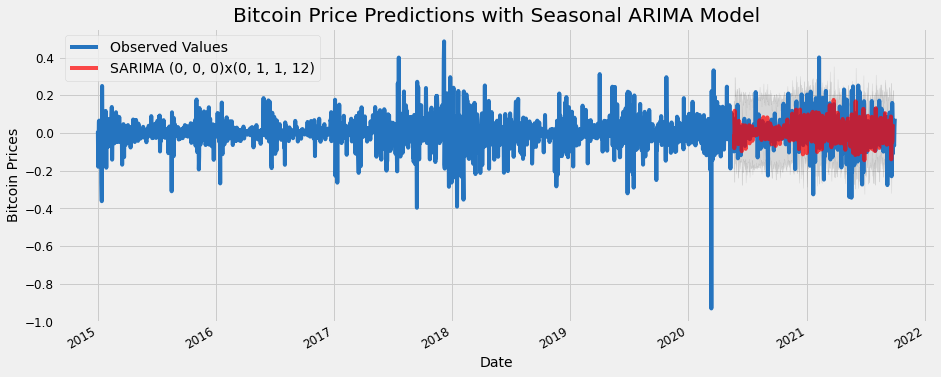

In [48]:
# Plot of observed values
ax = data.cox_diff.plot(label = 'Observed Values', color = '#2574BF')

# Plot of predicted values
sarima_predict_1.predicted_mean.plot(ax = ax, 
                                     label = 'SARIMA (0, 0, 0)x(0, 1, 1, 12)', 
                                     alpha = 0.7, 
                                     color = 'red') 

# Confidence Interval
ax.fill_between(sarima_predict_conf_1.index,
                # lower limit
                sarima_predict_conf_1.iloc[:, 0],
                # upper limit
                sarima_predict_conf_1.iloc[:, 1], color = 'k', alpha = 0.1)

# Title and legend
plt.title('Bitcoin Price Predictions with Seasonal ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Bitcoin Prices')
plt.legend()
plt.show()

Tranforming back to the original values. For this, it is used the functions previously defined. First, we invert the differentiation and then the Box Cox transformation.

In [52]:
# getting real values
sarima_pred = inverse_difference(testset['Close_Box'], sarima_predict_1.predicted_mean)
sarima_pred = inv_boxcox(sarima_pred, lmbda)
sarima_pred = pd.DataFrame(sarima_pred)
sarima_pred = pd.concat([x, sarima_pred])
sarima_pred.reset_index()
sarima_pred = sarima_pred.set_index(testset[:-2].index)

# Getting real values to lower limit
lower = inverse_difference(testset['Close_Box'], sarima_predict_conf_1.iloc[:, 0])
lower = inv_boxcox(lower, lmbda)

# Getting real values to upper limit
upper = inverse_difference(testset['Close_Box'], sarima_predict_conf_1.iloc[:, 1])
upper = inv_boxcox(upper, lmbda)

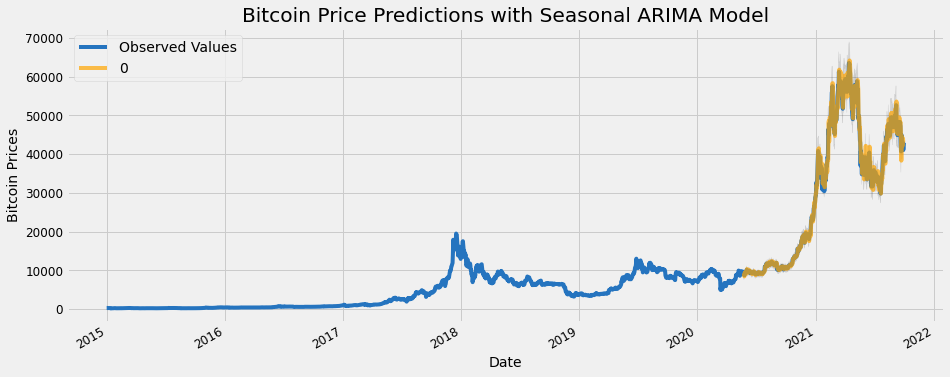

In [53]:
# Plot real values
# Plot of observed values
ax = data.Close.plot(label = 'Observed Values', color = '#2574BF')

# Plot of predicted values
sarima_pred[1:].plot(ax = ax, label = 'SARIMA', alpha = 0.7,
                 color = 'orange') 

# Confidence Interval
ax.fill_between(sarima_predict_conf_1.index[1:],
                # lower limit
                lower,
                # upper limit
                upper, color = 'k', alpha = 0.1)

# Title and legend
plt.title('Bitcoin Price Predictions with Seasonal ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Bitcoin Prices')
plt.legend()
plt.show()

## SARIMA Performance

In [54]:
# Performance
arima_results = performance(testset['Close'].values, sarima_pred.values)
arima_results

MSE of predictions is 609001505.24
RMSE of predictions is 24677.96
MAPE of predictions is 99.7


SARIMA MAPE (99.7) was greater than ARIMA MAPE (98.06), indicating that ARIMA has minor error.

## Prophet

In [55]:
# Create model with Anual Seasonality
model_prophet = Prophet(yearly_seasonality = True)

In [56]:
# Add Built-in Country Holiday
model_prophet.add_country_holidays(country_name = 'US')

In [57]:
# format target dataset
t = data.cox_diff.reset_index()
t = t.rename(columns = {'Date': 'ds', 'cox_diff': 'y'})

In [58]:
# Train model
model_prophet.fit(t) 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [59]:
# Dataset for predictions
dataset_pred = model_prophet.make_future_dataframe(periods = 365, freq = 'd')
dataset_pred.count()

ds    2826
dtype: int64

In [60]:
# Forecast
forecast_model_prophet = model_prophet.predict(dataset_pred)

In [61]:
# Predictions
forecast_model_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
2821 2022-09-26  0.005081   -0.097506    0.104147
2822 2022-09-27 -0.003191   -0.105380    0.097730
2823 2022-09-28  0.001684   -0.095455    0.107370
2824 2022-09-29  0.001515   -0.102826    0.100399
2825 2022-09-30  0.006634   -0.086259    0.109035

In [62]:
# Plot Predictions
fig = model_prophet.plot(forecast_model_prophet)

# Testset red
plt.plot(testset['cox_diff'], label = 'Test', color = 'red', linewidth = 2)
plt.show()

In [63]:
# Predictions
forecast_model_prophet.head()

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  Christmas Day  Christmas Day_lower  Christmas Day_upper  Christmas Day (Observed)  Christmas Day (Observed)_lower  Christmas Day (Observed)_upper  Columbus Day  Columbus Day_lower  Columbus Day_upper  Independence Day  Independence Day_lower  Independence Day_upper  Independence Day (Observed)  Independence Day (Observed)_lower  Independence Day (Observed)_upper  Juneteenth National Independence Day  Juneteenth National Independence Day_lower  Juneteenth National Independence Day_upper  Labor Day  Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  New Year's Day_lower  New Year's Day_upper  New Year's Day (Observed)  New Year's Day (Observed)_lower  New Year's Day (Observed)_upper  Thanksgiving  Thanksgiving_lower  Thanksgiving_upper  Veterans Day  Veterans Day_lower  Veterans Day_upper  Veterans Day (Observed)  Veterans Day (Observed)_lower  Veterans Day (Observed)_upper  Washington's Birthday  Washington's Birthday_lower  Washington's Birthday_upper  additive_terms  additive_terms_lower  additive_terms_upper  holidays  holidays_lower  holidays_upper    weekly  weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  multiplicative_terms  multiplicative_terms_lower  multiplicative_terms_upper      yhat
0 2015-01-01  0.001641   -0.089281    0.112805     0.001641     0.001641            0.0                  0.0                  0.0                       0.0                             0.0                             0.0           0.0                 0.0                 0.0               0.0                     0.0                     0.0                          0.0                                0.0                                0.0                                   0.0                                         0.0                                         0.0        0.0              0.0              0.0                         0.0                               0.0                               0.0           0.0                 0.0                 0.0        0.005946              0.005946              0.005946                        0.0                              0.0                              0.0           0.0                 0.0                 0.0           0.0                 0.0                 0.0                      0.0                            0.0                            0.0                    0.0                          0.0                          0.0        0.006156              0.006156              0.006156  0.005946        0.005946        0.005946 -0.000979     -0.000979     -0.000979  0.001189      0.001189      0.001189                   0.0                         0.0                         0.0  0.007797
1 2015-01-02  0.001646   -0.091687    0.110663     0.001646     0.001646            0.0                  0.0                  0.0                       0.0                             0.0                             0.0           0.0                 0.0                 0.0               0.0                     0.0                     0.0                          0.0                                0.0                                0.0                                   0.0                                         0.0                                         0.0        0.0              0.0              0.0                         0.0                               0.0                               0.0           0.0                 0.0                 0.0        0.000000              0.000000              0.000000                        0.0                              0.0                              0.0           0.0                 0.0                 0.0           0.0                 0.0                 0.0                      0.0                            0.0                        

In [64]:
# Clean zeros
forecast_model_prophet.drop(columns = ['multiplicative_terms', 
                                        'multiplicative_terms_lower',
                                        'multiplicative_terms_upper'], inplace = True)

Plot with transformed values.

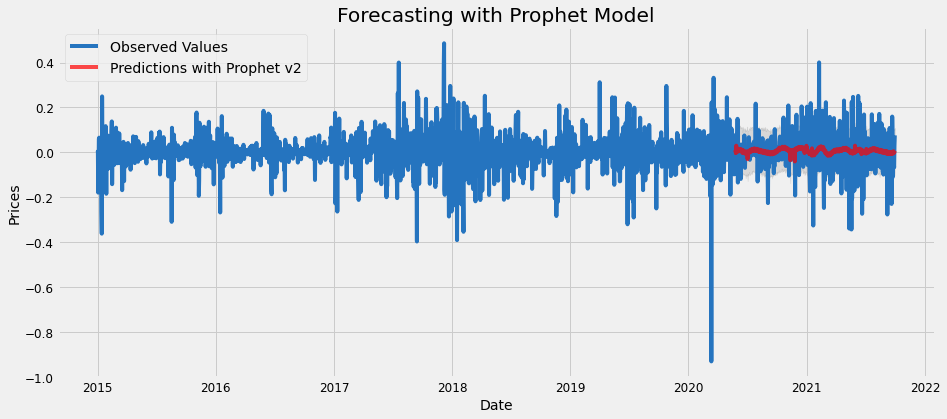

In [65]:
# Plot

# Original Serie
plt.plot(data.cox_diff.index, 
         data.cox_diff.values,
         label = 'Observed Values',
         color = '#2574BF')

i1 = len(forecast_model_prophet)-len(testset)

# Predictions
plt.plot(testset.cox_diff.index, 
         forecast_model_prophet[i1:]['yhat'].values,
         label = 'Predictions with Prophet v2', 
         alpha = 0.7, 
         color = 'red')

# Confidence Limits
plt.fill_between(testset.cox_diff.index,
                 forecast_model_prophet[i1:]['yhat_lower'].values,
                 forecast_model_prophet[i1:]['yhat_upper'].values, 
                 color = 'k', 
                 alpha = 0.1)

plt.title('Forecasting with Prophet Model')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [66]:
forecast_model_prophet.head()

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  Christmas Day  Christmas Day_lower  Christmas Day_upper  Christmas Day (Observed)  Christmas Day (Observed)_lower  Christmas Day (Observed)_upper  Columbus Day  Columbus Day_lower  Columbus Day_upper  Independence Day  Independence Day_lower  Independence Day_upper  Independence Day (Observed)  Independence Day (Observed)_lower  Independence Day (Observed)_upper  Juneteenth National Independence Day  Juneteenth National Independence Day_lower  Juneteenth National Independence Day_upper  Labor Day  Labor Day_lower  Labor Day_upper  Martin Luther King Jr. Day  Martin Luther King Jr. Day_lower  Martin Luther King Jr. Day_upper  Memorial Day  Memorial Day_lower  Memorial Day_upper  New Year's Day  New Year's Day_lower  New Year's Day_upper  New Year's Day (Observed)  New Year's Day (Observed)_lower  New Year's Day (Observed)_upper  Thanksgiving  Thanksgiving_lower  Thanksgiving_upper  Veterans Day  Veterans Day_lower  Veterans Day_upper  Veterans Day (Observed)  Veterans Day (Observed)_lower  Veterans Day (Observed)_upper  Washington's Birthday  Washington's Birthday_lower  Washington's Birthday_upper  additive_terms  additive_terms_lower  additive_terms_upper  holidays  holidays_lower  holidays_upper    weekly  weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper      yhat
0 2015-01-01  0.001641   -0.089281    0.112805     0.001641     0.001641            0.0                  0.0                  0.0                       0.0                             0.0                             0.0           0.0                 0.0                 0.0               0.0                     0.0                     0.0                          0.0                                0.0                                0.0                                   0.0                                         0.0                                         0.0        0.0              0.0              0.0                         0.0                               0.0                               0.0           0.0                 0.0                 0.0        0.005946              0.005946              0.005946                        0.0                              0.0                              0.0           0.0                 0.0                 0.0           0.0                 0.0                 0.0                      0.0                            0.0                            0.0                    0.0                          0.0                          0.0        0.006156              0.006156              0.006156  0.005946        0.005946        0.005946 -0.000979     -0.000979     -0.000979  0.001189      0.001189      0.001189  0.007797
1 2015-01-02  0.001646   -0.091687    0.110663     0.001646     0.001646            0.0                  0.0                  0.0                       0.0                             0.0                             0.0           0.0                 0.0                 0.0               0.0                     0.0                     0.0                          0.0                                0.0                                0.0                                   0.0                                         0.0                                         0.0        0.0              0.0              0.0                         0.0                               0.0                               0.0           0.0                 0.0                 0.0        0.000000              0.000000              0.000000                        0.0                              0.0                              0.0           0.0                 0.0                 0.0           0.0                 0.0                 0.0                      0.0                            0.0                            0.0                    0.0                          0.0                          0.0        0.003357              0.003357              0.003357  0.0000

In [67]:
# Performance
prophet_results = performance(testset.cox_diff.values, forecast_model_prophet[i1:]['yhat'])
prophet_results

MSE of predictions is 0.01
RMSE of predictions is 0.09
MAPE of predictions is 184.44


Prophet MAPE is also greater than ARIMA and SARIMA MAPE, indicating that ARIMA is the model with minor percentage error.

In [68]:
# Dataset to predictions - freq by day
dataset_pred = model_prophet.make_future_dataframe(periods = 365, freq = 'd')

In [69]:
# Forecast
forecast_model_prophet_60 = model_prophet.predict(dataset_pred)

Plot of train set, validation set, predictions in red and a period of 60 forecasting.

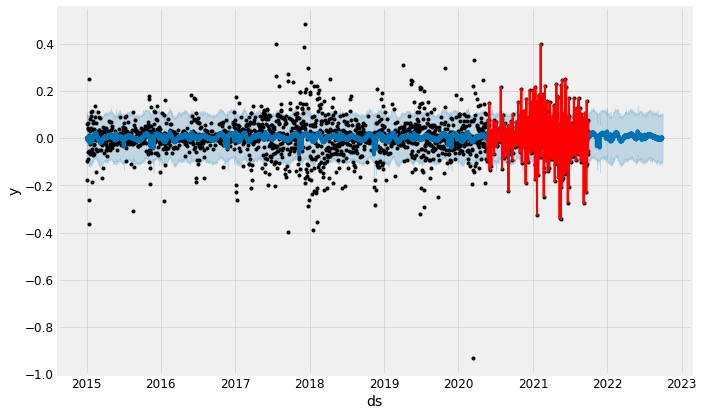

In [70]:
# Plot Predictions
fig = model_prophet.plot(forecast_model_prophet_60)

# Testset red
plt.plot(testset['cox_diff'], label = 'Teste', color = 'red', linewidth = 2)
plt.show()

Plotting the real values

In [71]:
# getting real values
i2 = len(data['Close_Box'])
prophet_pred = inverse_difference(data['Close_Box'], forecast_model_prophet[:i2].yhat)
prophet_pred = inv_boxcox(prophet_pred, lmbda)
prophet_pred = pd.DataFrame(prophet_pred)
prophet_pred = pd.concat([x, prophet_pred])
prophet_pred = prophet_pred.reset_index()
prophet_pred = prophet_pred.set_index(data.index)

# Getting real values to lower limit
lower = inverse_difference(data['Close_Box'], forecast_model_prophet[:i2].yhat_lower)
lower = inv_boxcox(lower, lmbda)

# Getting real values to upper limit
upper = inverse_difference(data['Close_Box'], forecast_model_prophet[:i2].yhat_upper)
upper = inv_boxcox(upper, lmbda)

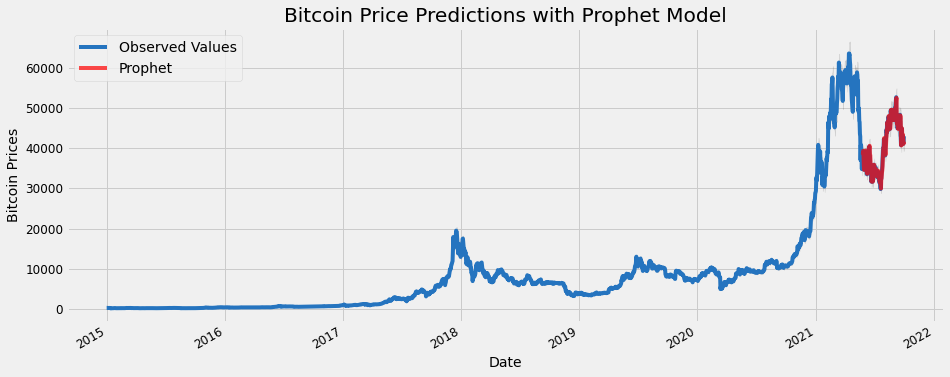

In [74]:
# Plot real values
# Plot of observed values
ax = data.Close.plot(label = 'Observed Values', color = '#2574BF')

# Plot of predicted values
prophet_pred[i1:][0].plot(ax = ax, label = 'Prophet', alpha = 0.7,
                 color = 'red') 

# Confidence Interval
ax.fill_between(prophet_pred.index[1:],
                # lower limit
                lower,
                # upper limit
                upper, color = 'k', alpha = 0.1)

# Title and legend
plt.title('Bitcoin Price Predictions with Prophet Model')
plt.xlabel('Date')
plt.ylabel('Bitcoin Prices')
plt.legend()
plt.show()